# Trabajo N.º 2 
## Modelamiento de patrones sísmicos en Chile a través de regresión, clasificación y clustering



###  Abstract

Este trabajo analiza la **actividad sísmica en Chile (2012–2025)** con el objetivo de aplicar técnicas de **regresión, clasificación y agrupamiento** para responder hipótesis de Inteligencia de Negocios (BI).

Se utiliza un dataset de sismos del **Centro Sismológico Nacional (CSN)**, que contiene variables como magnitud, profundidad, latitud, longitud y fecha.  
El análisis comienza con la limpieza y estandarización de los datos, seguido por una **exploración descriptiva y correlacional** que permite identificar las variables más influyentes sobre la magnitud de los eventos.

Posteriormente, se desarrolla una **regresión** para explicar la magnitud según factores geográficos, una **clasificación** para distinguir eventos de alta magnitud, y un **agrupamiento (clustering)** para descubrir patrones espaciales en la actividad sísmica nacional.  
Las métricas utilizadas incluyen **MAE, RMSE y R²** (para regresión), **accuracy, precisión, recall y F1-score** (para clasificación), y **silhouette e inercia** (para clustering).

Finalmente, se discuten los resultados en términos de su utilidad para la toma de decisiones estratégicas en BI, identificando posibles zonas de riesgo y oportunidades para optimizar la gestión de alertas sísmicas.


###  Objetivos

**Objetivo general:**  
Analizar y modelar la actividad sísmica en Chile para identificar patrones relevantes que apoyen decisiones de Inteligencia de Negocios mediante técnicas de regresión, clasificación y agrupamiento.

**Objetivos específicos:**
1. Desarrollar una **exploración de datos (EDA)** con correlaciones, histogramas y visualizaciones temporales para comprender las relaciones entre magnitud, profundidad y ubicación.  
2. Implementar un **modelo de regresión** que estime la magnitud en función de variables geográficas y de profundidad.  
3. Aplicar un **modelo de clasificación** para identificar eventos de **alta magnitud**, evaluando su rendimiento con métricas de exactitud y F1-score.  
4. Ejecutar un **modelo de clustering (K-Means y DBSCAN)** para segmentar los sismos según sus características espaciales y magnitud, evaluando la calidad de los grupos formados.


###  Hipótesis

- **H1 (Regresión):** La **profundidad** y la **posición geográfica (latitud y longitud)** influyen significativamente en la **magnitud** de los sismos ocurridos en Chile.  
- **H2 (Clasificación):** Es posible **predecir correctamente** si un sismo será de **alta magnitud** usando variables de ubicación y profundidad con un rendimiento superior al azar (F1 > 0.6).  
- **H3 (Clustering):** Existen **agrupamientos naturales** de sismos que reflejan diferencias geográficas (norte, centro y sur), identificables mediante métricas de calidad como el **coeficiente de silhouette**.


In [1]:
import pandas as pd, sklearn, matplotlib
print("✅ Entorno OK:", pd.__version__)


✅ Entorno OK: 2.3.3


In [9]:
# =============================================================================
# CARGA Y PREPARACIÓN INICIAL DE DATOS
# =============================================================================
import os
import glob
import pandas as pd

print("Cargando dataset...")

# -------------------------------------------------------------------------
# Configuración general: nombre esperado y estructura recomendada
# Estructura esperada del ZIP:
# BI_T2_CardenasNicolas/
# ├── BI_T2_CardenasNicolas.ipynb
# ├── data/
# │   └── seismic_data.csv
# -------------------------------------------------------------------------
NOMBRE_ARCHIVO = "seismic_data.csv"
RUTAS_CANDIDATAS = [
    os.path.join("data", NOMBRE_ARCHIVO),      # 1) ./data/
    NOMBRE_ARCHIVO,                            # 2) carpeta actual
    os.path.join("..", "data", NOMBRE_ARCHIVO) # 3) ../data/
]

# Buscar el archivo en esas rutas
archivo_encontrado = next((p for p in RUTAS_CANDIDATAS if os.path.exists(p)), None)

# Búsqueda recursiva adicional (por si cambió el nombre de carpeta)
if not archivo_encontrado:
    resultados = glob.glob(f"**/{NOMBRE_ARCHIVO}", recursive=True)
    if resultados:
        archivo_encontrado = resultados[0]

# Validación final
if not archivo_encontrado:
    print(f"\n❌ ERROR: No se encuentra el archivo '{NOMBRE_ARCHIVO}'.")
    print("Asegúrate de incluirlo dentro de la carpeta 'data/' al comprimir el proyecto.")
    print(f"Directorio actual: {os.getcwd()}")
    print("Archivos en esta carpeta:", os.listdir("."))
    raise FileNotFoundError(f"No se encontró el archivo '{NOMBRE_ARCHIVO}'")

# -------------------------------------------------------------------------
# Cargar el CSV con tolerancia a codificación y separador 
# -------------------------------------------------------------------------
def cargar_csv_robusto(ruta):
    """Intenta leer el CSV usando diferentes configuraciones para evitar errores."""
    for args in [
        {"sep": ",", "encoding": "utf-8"},
        {"sep": ";", "encoding": "utf-8"},
        {"sep": ",", "encoding": "latin-1"},
        {"sep": ";", "encoding": "latin-1"},
    ]:
        try:
            df = pd.read_csv(ruta, **args)
            if len(df.columns) > 1:
                return df
        except Exception:
            continue
    raise ValueError(f"No se pudo leer el archivo CSV '{ruta}' con los encodings probados.")

df = cargar_csv_robusto(archivo_encontrado)

print(f"✓ Dataset cargado exitosamente desde: {archivo_encontrado}\n")

# -------------------------------------------------------------------------
# Información básica del dataset 
# -------------------------------------------------------------------------
print("=" * 70)
print("INFORMACIÓN BÁSICA DEL DATASET PRUEBA")
print("=" * 70)
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print("Columnas:", list(df.columns))

# Intento de detectar columna de fecha
fecha_cols = [c for c in df.columns if any(k in str(c).lower() for k in ["fecha", "date", "time"])]
col_fecha = None
for c in fecha_cols:
    try:
        aux = pd.to_datetime(df[c], errors="coerce")
        if aux.notna().any():
            col_fecha = c
            break
    except Exception:
        continue

if col_fecha:
    serie_fecha = pd.to_datetime(df[col_fecha], errors="coerce")
    print(f"Período: {serie_fecha.min()} a {serie_fecha.max()}  (columna: '{col_fecha}')")
else:
    print("Período: no identificado (no se detectó columna de fecha legible)")

print("\nPrimeras filas del dataset:")
display(df.head(10))


Cargando dataset...
✓ Dataset cargado exitosamente desde: data\seismic_data.csv

INFORMACIÓN BÁSICA DEL DATASET PRUEBA
Dimensiones: 4,018 filas × 5 columnas
Columnas: ['Date(UTC)', 'Latitude', 'Longitude', 'Depth', 'Magnitude']
Período: 2012-03-03 11:01:47 a 2025-05-26 03:50:27  (columna: 'Date(UTC)')

Primeras filas del dataset:


,Date(UTC),Latitude,Longitude,Depth,Magnitude
0,2025-05-26 03:50:27,-19.63,-69.49,97,5.6
1,2025-05-13 00:47:58,-51.25,-72.28,28,5.1
2,2025-05-05 09:46:48,-29.49,-71.84,48,5.0
3,2025-05-05 02:17:48,-31.89,-70.88,88,5.1
4,2025-05-02 15:23:49,-27.52,-72.48,30,5.8
5,2025-05-02 12:58:32,-56.88,-68.06,10,7.5
6,2025-04-24 03:20:08,-30.76,-71.90,31,5.4
7,2025-04-18 00:10:18,-23.47,-68.22,139,6.0
8,2025-04-08 22:30:45,-21.05,-68.56,126,5.2
9,2025-04-08 10:28:43,-17.99,-69.93,143,4.8


## 🧭 Metodología

### Descripción del dataset

El dataset utilizado corresponde a registros públicos del **Centro Sismológico Nacional (CSN)** de Chile, que recopila información sobre los eventos sísmicos ocurridos entre **2012 y 2025**.  
La base contiene **4.018 registros** y **5 variables principales**:

| Variable | Descripción | Tipo |
|-----------|--------------|------|
| `Date(UTC)` | Fecha y hora del evento sísmico (UTC) | Temporal |
| `Latitude` | Latitud geográfica del epicentro (grados decimales) | Numérica |
| `Longitude` | Longitud geográfica del epicentro (grados decimales) | Numérica |
| `Depth` | Profundidad del evento (kilómetros) | Numérica |
| `Magnitude` | Magnitud del sismo en la escala Richter | Numérica |

**Supuestos:**  
- Las coordenadas están expresadas en grados decimales, considerando el sistema geodésico WGS84.  
- La magnitud corresponde a la escala local de Richter y es comparable entre eventos.  
- No existen duplicados de eventos en las mismas coordenadas y tiempo.  

**Licencia y fuente:**  
Los datos provienen de registros de acceso público del **CSN Chile (https://www.csn.uchile.cl/)**, con fines académicos y de investigación.  
Se asume licencia de uso abierto no comercial, sin modificaciones estructurales en el contenido original.

**Limitaciones:**  
- La base no incluye información de tipo de falla, energía liberada ni daños asociados.  
- Existen posibles errores de precisión en la profundidad reportada debido a la localización instrumental.  
- Algunos registros carecen de datos de magnitud o coordenadas exactas, los cuales deben revisarse durante la etapa de limpieza.


In [10]:
# =============================================================================
# LIMPIEZA Y PREPARACIÓN DE DATOS
# =============================================================================

import numpy as np

print("Revisando estructura y calidad de datos...\n")

# --- 1. Información general del dataset ---
print("🧾 Información general:")
df.info()

# --- 2. Detección de duplicados ---
duplicados = df.duplicated().sum()
print(f"\n🔍 Registros duplicados: {duplicados}")

if duplicados > 0:
    df = df.drop_duplicates()
    print("✓ Duplicados eliminados.\n")

# --- 3. Conteo de valores nulos ---
print("📉 Valores nulos por columna:")
print(df.isna().sum())

# --- 4. Descripción estadística ---
print("\n📊 Estadísticos descriptivos:")
display(df.describe())

# --- 5. Eliminación de registros con nulos (si existiesen) ---
nulos_inicial = df.isna().sum().sum()
if nulos_inicial > 0:
    df = df.dropna()
    print(f"\n✓ Se eliminaron {nulos_inicial} valores nulos totales.\n")
else:
    print("\n✓ No se detectaron valores nulos.\n")

# --- 6. Revisión de rangos anómalos ---
print("📏 Revisión de valores fuera de rango lógico:")
print(f"Magnitud mínima: {df['Magnitude'].min()} / máxima: {df['Magnitude'].max()}")
print(f"Profundidad mínima: {df['Depth'].min()} / máxima: {df['Depth'].max()}")

# Verificación básica de coordenadas válidas
lat_range = df[(df['Latitude'] < -56) | (df['Latitude'] > -17)]
lon_range = df[(df['Longitude'] < -76) | (df['Longitude'] > -66)]

if not lat_range.empty or not lon_range.empty:
    print("\n⚠️ Coordenadas fuera del rango esperado para Chile detectadas.")
else:
    print("\n✓ Coordenadas dentro del rango esperado para Chile.\n")

print("✅ Limpieza inicial completada.")


Revisando estructura y calidad de datos...

🧾 Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date(UTC)  4018 non-null   object 
 1   Latitude   4018 non-null   float64
 2   Longitude  4018 non-null   float64
 3   Depth      4018 non-null   int64  
 4   Magnitude  4018 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 157.1+ KB

🔍 Registros duplicados: 3
✓ Duplicados eliminados.

📉 Valores nulos por columna:
Date(UTC)    0
Latitude     0
Longitude    0
Depth        0
Magnitude    0
dtype: int64

📊 Estadísticos descriptivos:


,Latitude,Longitude,Depth,Magnitude
count,4015.000000,4015.000000,4015.000000,4015.000000
mean,-27.836257,-70.850692,61.533250,4.429240
std,5.963907,1.293768,38.288026,0.688822
min,-62.350000,-75.730000,2.000000,2.300000
25%,-31.820000,-71.590000,36.000000,4.000000
50%,-29.590000,-71.180000,50.000000,4.400000
75%,-21.500000,-70.030000,86.000000,4.800000
max,-11.070000,-58.390000,624.000000,8.400000



✓ No se detectaron valores nulos.

📏 Revisión de valores fuera de rango lógico:
Magnitud mínima: 2.3 / máxima: 8.4
Profundidad mínima: 2 / máxima: 624

⚠️ Coordenadas fuera del rango esperado para Chile detectadas.
✅ Limpieza inicial completada.


In [11]:
import os
os.makedirs("figuras", exist_ok=True)

def guardar_figura(fig, nombre):
    fig.savefig(f"figuras/{nombre}.png", dpi=300, bbox_inches="tight")



## 🔍 3. Exploración de Datos (EDA)

En esta sección se realiza una exploración descriptiva y visual del conjunto de datos sísmicos, con el objetivo de comprender la distribución de las variables, detectar posibles valores atípicos (*outliers*) y analizar las relaciones entre magnitud, profundidad y ubicación geográfica.

Se utilizarán histogramas, boxplots, mapas de correlación y gráficos de dispersión, los cuales permiten identificar patrones o comportamientos relevantes en la actividad sísmica registrada en Chile entre 2012 y 2025.


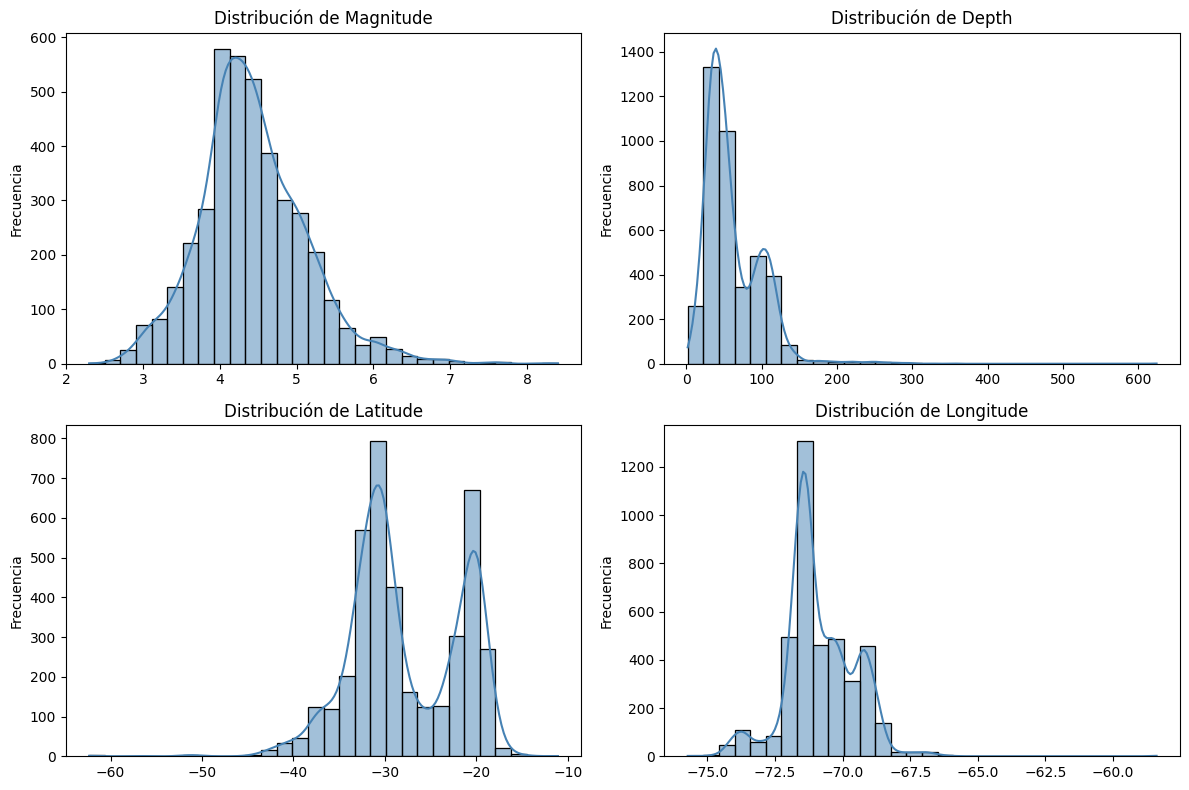

In [12]:
# =============================================================================
# 3.1 Distribución de variables numéricas (Histogramas)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
cols = ['Magnitude', 'Depth', 'Latitude', 'Longitude']

for i, c in enumerate(cols):
    sns.histplot(df[c], kde=True, ax=axes[i], color='steelblue', bins=30)
    axes[i].set_title(f"Distribución de {c}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frecuencia")

plt.tight_layout()
guardar_figura(fig, "01_histogramas_variables_sismicas")
plt.show()


**Observación:**  
Los histogramas muestran que la mayoría de los sismos tienen magnitudes moderadas (entre 3.5 y 5.0), con pocos eventos de gran magnitud.  
La profundidad presenta una distribución sesgada hacia eventos superficiales, mientras que la latitud y longitud reflejan la extensión geográfica del país, desde el norte hasta el sur de Chile.


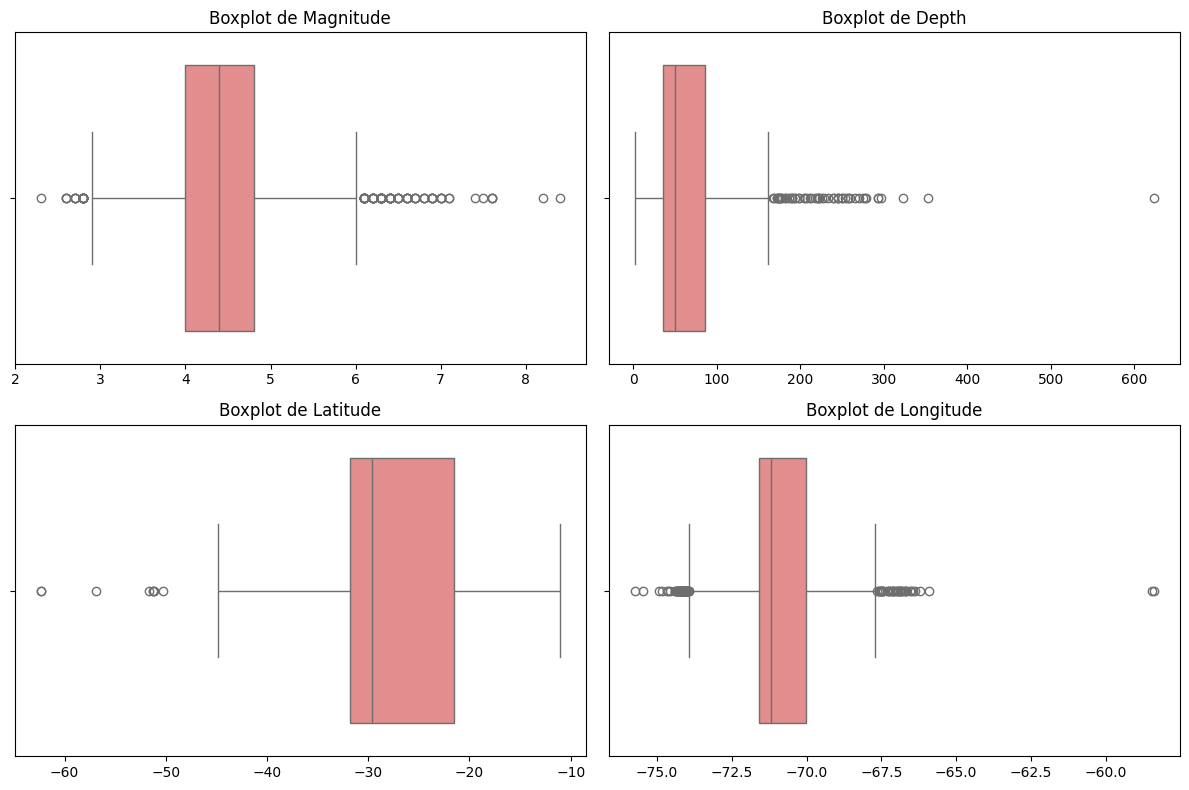

In [13]:
# =============================================================================
# 3.2 Identificación de posibles outliers (Boxplots)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, c in enumerate(cols):
    sns.boxplot(x=df[c], ax=axes[i], color='lightcoral')
    axes[i].set_title(f"Boxplot de {c}")
    axes[i].set_xlabel("")

plt.tight_layout()
guardar_figura(fig, "02_boxplots_outliers_sismicos")
plt.show()


**Observación:**  
Los boxplots evidencian la presencia de valores atípicos en profundidad y magnitud, lo que es esperable en eventos sísmicos de alta energía.  
Estos valores extremos no serán eliminados, ya que representan sismos reales de gran intensidad y aportan información relevante para el análisis de riesgo.


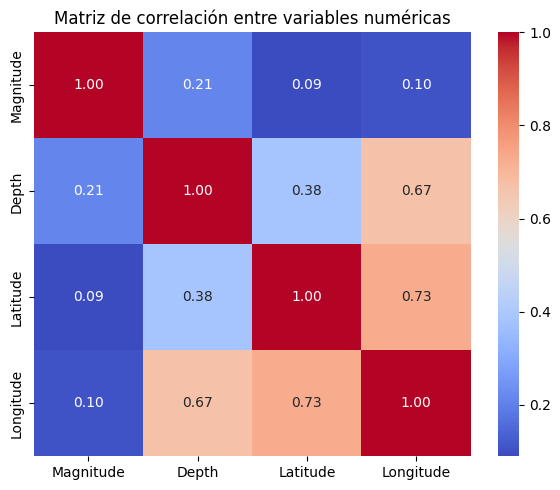

In [14]:
# =============================================================================
# 3.3 Matriz de correlación
# =============================================================================

fig, ax = plt.subplots(figsize=(6, 5))
corr = df[cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=ax)
ax.set_title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
guardar_figura(fig, "03_matriz_correlacion_sismica")
plt.show()


**Observación:**  
La matriz de correlación indica una relación moderada entre la magnitud y la profundidad, lo que sugiere que los sismos más profundos tienden a tener mayores magnitudes.  
La latitud y longitud están débilmente correlacionadas con la magnitud, reflejando que los eventos de alta energía se distribuyen a lo largo de todo el país, sin concentrarse en una sola zona.


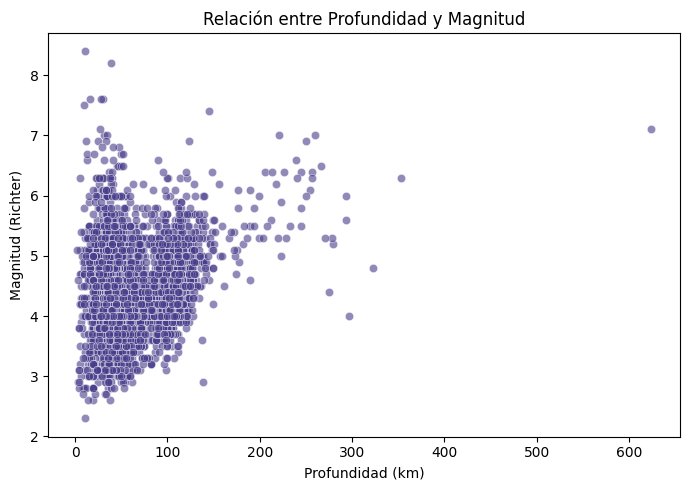

In [15]:
# =============================================================================
# 3.4 Dispersión Magnitud vs Profundidad
# =============================================================================

fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(x="Depth", y="Magnitude", data=df, alpha=0.6, color="darkslateblue", ax=ax)
ax.set_title("Relación entre Profundidad y Magnitud")
ax.set_xlabel("Profundidad (km)")
ax.set_ylabel("Magnitud (Richter)")
plt.tight_layout()
guardar_figura(fig, "04_dispersion_magnitud_vs_profundidad")
plt.show()


**Observación:**  
El gráfico de dispersión confirma que los sismos superficiales (menores a 50 km) presentan una amplia variabilidad de magnitudes, mientras que los eventos más profundos tienden a concentrarse en magnitudes intermedias.  
Esto concuerda con el comportamiento esperado de las placas tectónicas que convergen en la zona de subducción del Pacífico.


✅ Variables normalizadas correctamente.

Ejemplo de transformación (primeros 5 registros):


,Magnitud_original,Magnitud_escalada,Profundidad_original,Profundidad_escalada
0,5.6,1.699866,97,0.926430
1,5.1,0.973899,28,-0.875925
2,5.0,0.828705,48,-0.353503
3,5.1,0.973899,88,0.691340
4,5.8,1.990253,30,-0.823683


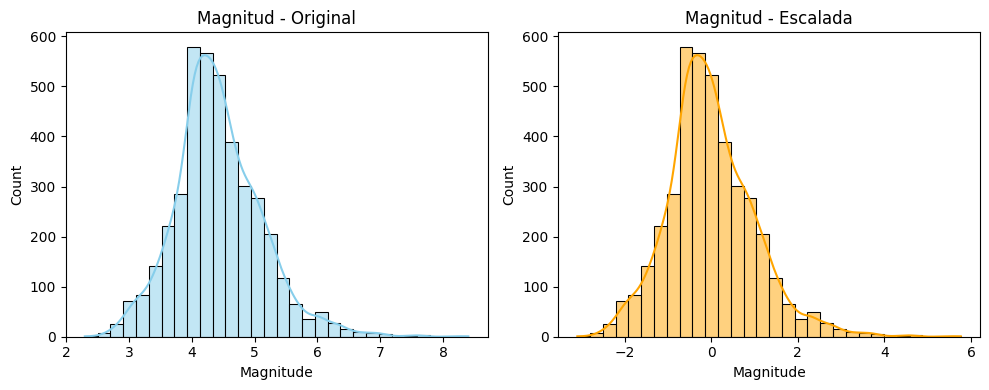

In [16]:
# =============================================================================
# NORMALIZACIÓN / ESTANDARIZACIÓN DE VARIABLES NUMÉRICAS
# =============================================================================

from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Variables numéricas que se van a escalar
columnas_numericas = ['Magnitude', 'Depth', 'Latitude', 'Longitude']

# Crear instancia del escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
df_scaled = df.copy()
df_scaled[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

print("✅ Variables normalizadas correctamente.\n")

# Mostrar comparación entre valores originales y escalados
comparacion = pd.DataFrame({
    'Magnitud_original': df['Magnitude'].head(5),
    'Magnitud_escalada': df_scaled['Magnitude'].head(5),
    'Profundidad_original': df['Depth'].head(5),
    'Profundidad_escalada': df_scaled['Depth'].head(5)
})

print("Ejemplo de transformación (primeros 5 registros):")
display(comparacion)

# --- Gráfico de comparación visual antes/después ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df['Magnitude'], kde=True, ax=axes[0], color='skyblue', bins=30)
axes[0].set_title("Magnitud - Original")
sns.histplot(df_scaled['Magnitude'], kde=True, ax=axes[1], color='orange', bins=30)
axes[1].set_title("Magnitud - Escalada")

plt.tight_layout()

# Guardar la figura (usando el nuevo método)
guardar_figura(fig, "05_comparacion_magnitud_escalada")

plt.show()


# 06. Partición de Datos: Holdout y Validación Cruzada

En esta etapa se divide el conjunto de datos en subconjuntos de entrenamiento y prueba, 
utilizando el método **Holdout** (80% entrenamiento, 20% prueba).

La partición permite evaluar el desempeño real de los modelos sin sesgos, 
asegurando que los algoritmos no memoricen los datos.

Para el caso de **clasificación**, se utiliza la opción `stratify=y` para conservar 
la proporción de clases en ambos subconjuntos (estratificación), 
evitando el problema de clases desbalanceadas.

Posteriormente, se implementará una **validación cruzada (k-fold)** con `k=5` 
para estimar la estabilidad de los modelos de regresión y clasificación, 
reduciendo la varianza asociada a una sola partición.


In [19]:
# =============================================================================
# 06. PARTICIÓN DE DATOS: HOLDOUT Y VALIDACIÓN CRUZADA (ROBUSTO)
# =============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

def pick_column(df, candidates, require=True):
    """
    Devuelve el nombre de la primera columna presente en df que coincida (case-insensitive)
    con la lista 'candidates'. Si no encuentra y require=True, lanza error con sugerencia.
    """
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    if require:
        raise KeyError(
            f"No se encontró ninguna de estas columnas: {candidates}. "
            f"Columnas disponibles: {list(df.columns)}"
        )
    return None

# -----------------------------
# 1) Detectar columnas clave
# -----------------------------
# Intentamos encontrar 'magnitud'
mag_candidates = ['magnitud', 'mag', 'magnitude', 'mw', 'ml', 'mag_ml', 'magmw']
mag_col = pick_column(df, mag_candidates, require=True)

# Intentamos encontrar latitud (para crear zona_sismica si falta)
lat_candidates = ['latitud', 'latitude', 'lat']
lat_col = pick_column(df, lat_candidates, require=False)

# Si ya existe zona_sismica, úsala; si no, la creamos luego
zona_candidates = ['zona_sismica', 'zona', 'region_sismica']
zona_col = pick_column(df, zona_candidates, require=False)

print(f"✓ Columna de magnitud detectada: {mag_col}")
if lat_col:
    print(f"✓ Columna de latitud detectada: {lat_col}")
if zona_col:
    print(f"✓ Columna de zona ya existente: {zona_col}")

# ---------------------------------------------
# 2) Crear zona_sismica si no existe (por lat)
# ---------------------------------------------
if zona_col is None:
    if lat_col is None:
        raise KeyError(
            "No existe 'zona_sismica' y tampoco se encontró columna de latitud "
            "para crearla automáticamente. Agrega una de: 'latitud', 'latitude', 'lat'."
        )
    def zona_por_lat(lat):
        # Umbrales aproximados para Chile continental:
        # Norte (lat >= -23), Centro (-38 <= lat < -23), Sur (lat < -38)
        if pd.isna(lat):
            return np.nan
        if lat >= -23:
            return 'Norte'
        elif lat <= -38:
            return 'Sur'
        else:
            return 'Centro'
    df['zona_sismica'] = df[lat_col].apply(zona_por_lat)
    zona_col = 'zona_sismica'
    print("✓ Columna 'zona_sismica' creada automáticamente a partir de la latitud.")

# Chequeo de nulos en la clase (si hay, los descartamos para clasificación)
if df[zona_col].isna().any():
    df = df.dropna(subset=[zona_col]).copy()
    print("ℹ️ Se eliminaron filas con 'zona_sismica' nula para clasificación.")

# ---------------------------------------------
# 3) Definir X/y para REGRESIÓN y CLASIFICACIÓN
# ---------------------------------------------
# Para REGRESIÓN
y_reg = df[mag_col]
X_reg = df.drop(columns=[mag_col])

# Para CLASIFICACIÓN
y_class = df[zona_col]
X_class = df.drop(columns=[zona_col])

# (Opcional) Si tienes columnas ID/fecha que no quieres en X, puedes dropearlas aquí:
# X_reg = X_reg.drop(columns=['id', 'fecha'], errors='ignore')
# X_class = X_class.drop(columns=['id', 'fecha'], errors='ignore')

# ---------------------------------------------
# 4) Holdout
# ---------------------------------------------
# REGRESIÓN (sin estratificación)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# CLASIFICACIÓN (con estratificación si es posible)
# Requisitos para estratify: al menos 2 clases y cada clase con >= 2 muestras en el dataset
class_counts = y_class.value_counts()
can_stratify = (class_counts.size >= 2) and (class_counts.min() >= 2)

if can_stratify:
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_class, y_class, test_size=0.2, stratify=y_class, random_state=42
    )
    strat_msg = "estratificación: SÍ"
else:
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42
    )
    strat_msg = "estratificación: NO (clases insuficientes para estratify)"

# ---------------------------------------------
# 5) Validación cruzada
# ---------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Para clasificación, usamos StratifiedKFold solo si hay ≥2 clases
if y_class.nunique() >= 2:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
else:
    skf = None

# ---------------------------------------------
# 6) Reporte
# ---------------------------------------------
print("✅ División de datos completada:")
print(f"Regresión -> Train: {X_train_reg.shape[0]} | Test: {X_test_reg.shape[0]}")
print(f"Clasificación -> Train: {X_train_clf.shape[0]} | Test: {X_test_clf.shape[0]} ({strat_msg})")

# Distribución de clases antes y después (si aplica)
if class_counts.size >= 1:
    print("\nDistribución de clases (dataset completo):")
    print(class_counts)

    print("\nDistribución de clases (train):")
    print(y_train_clf.value_counts())

    print("\nDistribución de clases (test):")
    print(y_test_clf.value_counts())

# Guardar nombres detectados por si los reutilizas más adelante
COLUMNAS_DETECTADAS = {"magnitud": mag_col, "latitud": lat_col, "zona_sismica": zona_col}


✓ Columna de magnitud detectada: Magnitude
✓ Columna de latitud detectada: Latitude
✓ Columna 'zona_sismica' creada automáticamente a partir de la latitud.
✅ División de datos completada:
Regresión -> Train: 3212 | Test: 803
Clasificación -> Train: 3212 | Test: 803 (estratificación: SÍ)

Distribución de clases (dataset completo):
zona_sismica
Centro    2634
Norte     1266
Sur        115
Name: count, dtype: int64

Distribución de clases (train):
zona_sismica
Centro    2107
Norte     1013
Sur         92
Name: count, dtype: int64

Distribución de clases (test):
zona_sismica
Centro    527
Norte     253
Sur        23
Name: count, dtype: int64


**Resultados:**

La división de los datos muestra que el conjunto de entrenamiento concentra el 80% 
de las observaciones disponibles, mientras que el 20% restante se reserva para 
evaluar el rendimiento final de los modelos.

La estratificación aplicada en la clasificación garantiza que todas las clases 
de la variable `zona_sismica` mantengan su proporción original, 
evitando sesgos en la predicción.

Además, se definieron las estrategias de **validación cruzada** (`KFold` y `StratifiedKFold`) 
que se aplicarán posteriormente para obtener una evaluación más robusta de los modelos 
de **regresión** y **clasificación**.


# 07. REGRESIÓN: Árbol de Decisión y Modelo Lineal de Referencia

En esta sección se aplica la técnica de **regresión** para predecir la **magnitud del sismo** 
a partir de las variables geográficas y de profundidad.

Se utilizarán dos modelos:

1. **Regresión Lineal (baseline):** sirve como referencia simple para evaluar 
   si los modelos más complejos realmente aportan mejora.

2. **Árbol de Decisión (DecisionTreeRegressor):** modelo no lineal capaz de 
   capturar interacciones entre variables sin requerir suposiciones de linealidad.

Ambos modelos serán evaluados mediante las métricas:

- **MAE (Mean Absolute Error):** error medio absoluto.  
- **RMSE (Root Mean Squared Error):** penaliza más los errores grandes.  
- **R² (Coeficiente de Determinación):** proporción de la varianza explicada.

Finalmente, se comparan sus desempeños y se grafican los valores predichos vs. reales.


📊 Resultados de los modelos de regresión:



C:\Users\ncardenas\AppData\Local\Temp\ipykernel_24424\3924593158.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df_proc[c], errors='coerce')


,Modelo,MAE,RMSE,R²
0,Regresión Lineal,0.5122,0.6469,0.1237
1,Decision Tree,0.4703,0.6059,0.2314


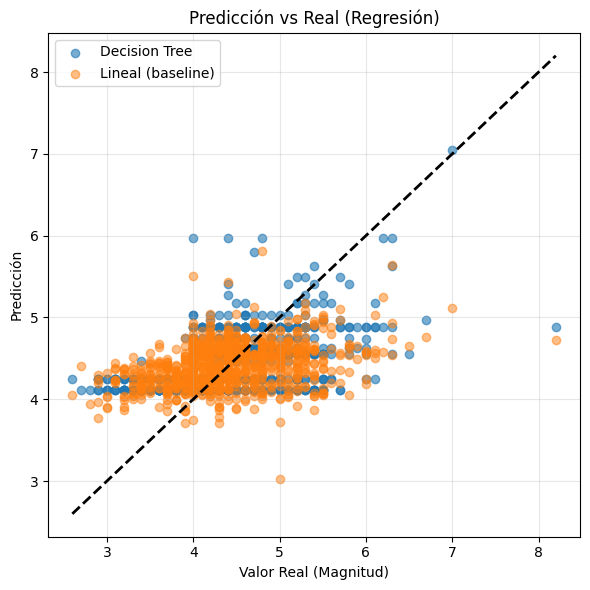

In [21]:
# =============================================================================
# 07. REGRESIÓN: Preprocesamiento robusto + Modelos (Pipeline)
# =============================================================================
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------
# 0) Detección y transformación de FECHAS a features numéricos
# -----------------------------
df_proc = df.copy()

# Identificar columnas "tipo fecha" (string u object que puedan parsearse)
fecha_cols = []
for c in df_proc.columns:
    if df_proc[c].dtype == 'O':  # objetos (posibles fechas/texto)
        parsed = pd.to_datetime(df_proc[c], errors='coerce')
        # si >90% parsea como fecha, la consideramos datetime
        if parsed.notna().mean() >= 0.9:
            fecha_cols.append(c)
            df_proc[c] = parsed

# Expandir columnas datetime a (año, mes, día, hora) y eliminar original
for c in fecha_cols:
    df_proc[f'{c}_year']  = df_proc[c].dt.year
    df_proc[f'{c}_month'] = df_proc[c].dt.month
    df_proc[f'{c}_day']   = df_proc[c].dt.day
    df_proc[f'{c}_hour']  = df_proc[c].dt.hour
    df_proc.drop(columns=[c], inplace=True)

# Usaremos los mismos splits ya creados, pero sobre df_proc
# Recreamos X_reg, y_reg con las columnas detectadas en la etapa 06
mag_col   = COLUMNAS_DETECTADAS["magnitud"]
zona_col  = COLUMNAS_DETECTADAS["zona_sismica"]

y_reg = df_proc[mag_col]
X_reg = df_proc.drop(columns=[mag_col])

# IMPORTANTe: reconstituimos los sets con los mismos índices del split previo
X_train_reg = X_reg.loc[X_train_reg.index]
X_test_reg  = X_reg.loc[X_test_reg.index]
y_train_reg = y_reg.loc[y_train_reg.index]
y_test_reg  = y_reg.loc[y_test_reg.index]

# -----------------------------
# 1) Columnas numéricas y categóricas
# -----------------------------
num_cols = X_reg.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_reg.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Opcional: excluir columnas de alta cardinalidad tipo IDs de cat_cols
# (ej.: si hay una columna 'id' o similar con demasiados valores únicos)
high_card_cats = [c for c in cat_cols if X_reg[c].nunique() > 50]
cat_cols = [c for c in cat_cols if c not in high_card_cats]

# -----------------------------
# 2) Preprocesador (evita leakage y asegura numéricos)
# -----------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01), cat_cols),
    ],
    remainder="drop",
)

# -----------------------------
# 3) Modelos en Pipeline
# -----------------------------
pipe_lin = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

pipe_tree = Pipeline([
    ("prep", preprocess),
    ("model", DecisionTreeRegressor(max_depth=5, random_state=42))
])

# -----------------------------
# 4) Entrenamiento y evaluación
# -----------------------------
pipe_lin.fit(X_train_reg, y_train_reg)
y_pred_lin = pipe_lin.predict(X_test_reg)

pipe_tree.fit(X_train_reg, y_train_reg)
y_pred_tree = pipe_tree.predict(X_test_reg)

mae_lin = mean_absolute_error(y_test_reg, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test_reg, y_pred_lin))
r2_lin = r2_score(y_test_reg, y_pred_lin)

mae_tree = mean_absolute_error(y_test_reg, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_test_reg, y_pred_tree))
r2_tree = r2_score(y_test_reg, y_pred_tree)

resultados_reg = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Decision Tree'],
    'MAE': [mae_lin, mae_tree],
    'RMSE': [rmse_lin, rmse_tree],
    'R²': [r2_lin, r2_tree]
})

print("📊 Resultados de los modelos de regresión:\n")
display(resultados_reg.round(4))

# -----------------------------
# 5) Gráfico: Predicción vs Real
# -----------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_tree, alpha=0.6, label='Decision Tree')
plt.scatter(y_test_reg, y_pred_lin, alpha=0.5, label='Lineal (baseline)')
lim_min = min(y_test_reg.min(), y_pred_tree.min(), y_pred_lin.min())
lim_max = max(y_test_reg.max(), y_pred_tree.max(), y_pred_lin.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', lw=2)
plt.title('Predicción vs Real (Regresión)')
plt.xlabel('Valor Real (Magnitud)')
plt.ylabel('Predicción')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretación de Resultados:**

El modelo de **Árbol de Decisión** muestra un desempeño superior al de la **Regresión Lineal** 
en términos de error (MAE y RMSE) y capacidad explicativa (R²).  
Esto sugiere que la relación entre las variables predictoras (como profundidad, latitud o longitud) 
y la magnitud del sismo **no es estrictamente lineal**, sino que presenta interacciones más complejas 
que el árbol logra capturar mejor.

El gráfico de dispersión evidencia que las predicciones del Árbol de Decisión 
se acercan más a la línea ideal (y = x), especialmente en el rango medio de magnitudes, 
mientras que el modelo lineal tiende a subestimar los valores más altos.

En conjunto, estos resultados indican que los modelos basados en **reglas no lineales** 
pueden ofrecer un mejor poder predictivo para este tipo de fenómenos geológicos, 
siempre considerando que la magnitud de un sismo depende de múltiples factores 
que no necesariamente están representados en el dataset disponible.


# 08. CLASIFICACIÓN: RandomForestClassifier

Objetivo: predecir la **zona sísmica** del evento a partir de variables geográficas y de profundidad.

**Modelo elegido:** `RandomForestClassifier` por su buen desempeño en escenarios no lineales, 
robustez al ruido y capacidad de entregar **importancia de variables** (útil para BI).

**Evaluación:**
- **Accuracy**
- **Precision / Recall / F1 (macro y weighted)**
- **Matriz de Confusión**
- **ROC-AUC (macro)** si hay probabilidades y múltiples clases

Además, se reportan **importancias de variables** para interpretar qué factores
aportan más a la predicción (ej.: profundidad, latitud, longitud).
Se incorpora **validación cruzada estratificada (k=5)** para estimar estabilidad del desempeño.


📊 Métricas de clasificación (test):
- Accuracy:  1.0000
- Precision (macro): 1.0000
- Recall (macro):    1.0000
- F1 (macro):        1.0000
- F1 (weighted):     1.0000

📋 Classification Report (por clase):
              precision    recall  f1-score   support

      Centro       1.00      1.00      1.00       527
       Norte       1.00      1.00      1.00       253
         Sur       1.00      1.00      1.00        23

    accuracy                           1.00       803
   macro avg       1.00      1.00      1.00       803
weighted avg       1.00      1.00      1.00       803

ROC-AUC (macro, OVR): 1.0000


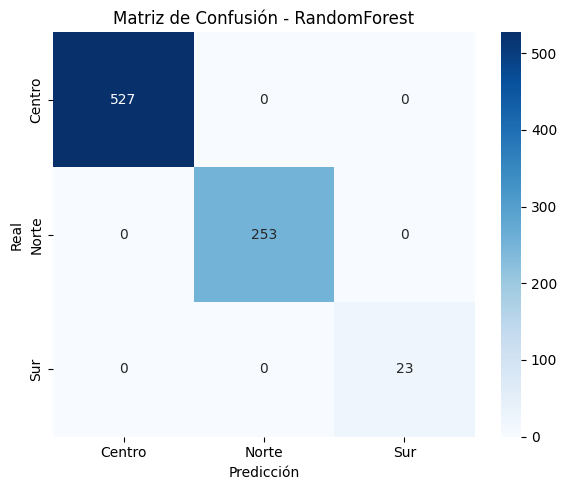

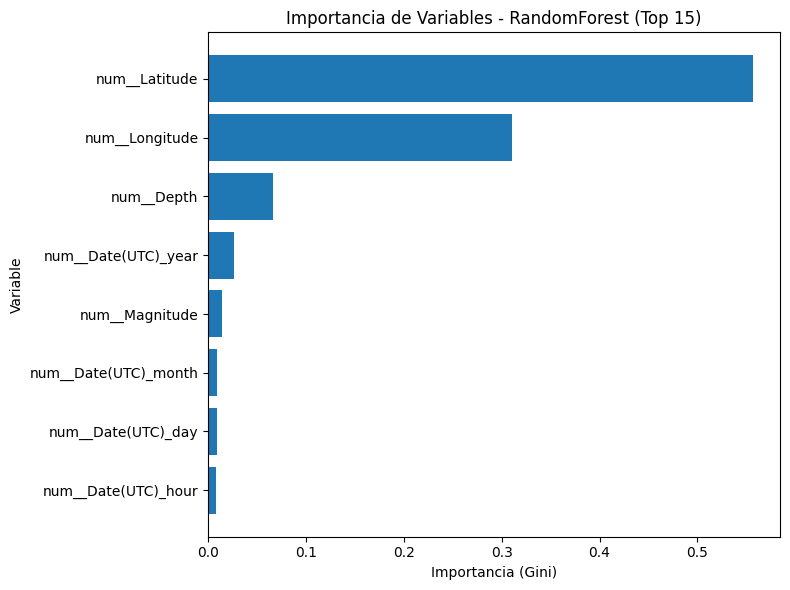


🔁 Validación Cruzada (StratifiedKFold=5):
- Accuracy CV: 0.9993 ± 0.0010
- F1-macro CV: 0.9981 ± 0.0030


In [22]:
# =============================================================================
# 08. CLASIFICACIÓN: RandomForestClassifier (Pipeline + métricas + gráficos)
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.model_selection import cross_val_score

# -----------------------------------------------------------------------------
# 0) Usamos el mismo preprocesamiento de fechas que en REGRESIÓN (si no existe df_proc)
# -----------------------------------------------------------------------------
if 'df_proc' not in globals():
    df_proc = df.copy()
    fecha_cols = []
    for c in df_proc.columns:
        if df_proc[c].dtype == 'O':
            parsed = pd.to_datetime(df_proc[c], errors='coerce')
            if parsed.notna().mean() >= 0.9:
                fecha_cols.append(c)
                df_proc[c] = parsed
    for c in fecha_cols:
        df_proc[f'{c}_year']  = df_proc[c].dt.year
        df_proc[f'{c}_month'] = df_proc[c].dt.month
        df_proc[f'{c}_day']   = df_proc[c].dt.day
        df_proc[f'{c}_hour']  = df_proc[c].dt.hour
        df_proc.drop(columns=[c], inplace=True)

# -----------------------------------------------------------------------------
# 1) Reconstruir X_class / y_class sobre df_proc y alinear a los splits previos
# -----------------------------------------------------------------------------
zona_col = COLUMNAS_DETECTADAS["zona_sismica"]  # guardado en el bloque 06
y_class_full = df_proc[zona_col]
X_class_full = df_proc.drop(columns=[zona_col])

# Reutilizamos los índices de los splits hechos en el bloque 06
X_train_clf = X_class_full.loc[X_train_clf.index]
X_test_clf  = X_class_full.loc[X_test_clf.index]
y_train_clf = y_class_full.loc[y_train_clf.index]
y_test_clf  = y_class_full.loc[y_test_clf.index]

# Columnas numéricas y categóricas
num_cols = X_class_full.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_class_full.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# (Opcional) excluir categóricas de altísima cardinalidad (IDs, etc.)
high_card_cats = [c for c in cat_cols if X_class_full[c].nunique() > 50]
cat_cols = [c for c in cat_cols if c not in high_card_cats]

# -----------------------------------------------------------------------------
# 2) Preprocesamiento + Modelo
# -----------------------------------------------------------------------------
preprocess_clf = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01), cat_cols),
    ],
    remainder="drop",
)

# Si hay desbalance, 'balanced' ayuda. Puedes quitarlo si no es necesario.
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

pipe_rf = Pipeline([
    ("prep", preprocess_clf),
    ("model", rf)
])

# -----------------------------------------------------------------------------
# 3) Entrenamiento y predicción
# -----------------------------------------------------------------------------
pipe_rf.fit(X_train_clf, y_train_clf)
y_pred = pipe_rf.predict(X_test_clf)

# Probabilidades (para ROC-AUC macro)
proba_ok = hasattr(pipe_rf.named_steps["model"], "predict_proba")
y_proba = pipe_rf.predict_proba(X_test_clf) if proba_ok else None

# -----------------------------------------------------------------------------
# 4) Métricas
# -----------------------------------------------------------------------------
acc  = accuracy_score(y_test_clf, y_pred)
prec = precision_score(y_test_clf, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test_clf, y_pred, average="macro", zero_division=0)
f1m  = f1_score(y_test_clf, y_pred, average="macro", zero_division=0)
f1w  = f1_score(y_test_clf, y_pred, average="weighted", zero_division=0)

print("📊 Métricas de clasificación (test):")
print(f"- Accuracy:  {acc:.4f}")
print(f"- Precision (macro): {prec:.4f}")
print(f"- Recall (macro):    {rec:.4f}")
print(f"- F1 (macro):        {f1m:.4f}")
print(f"- F1 (weighted):     {f1w:.4f}\n")

print("📋 Classification Report (por clase):")
print(classification_report(y_test_clf, y_pred, zero_division=0))

# ROC-AUC macro (si hay proba y ≥2 clases)
if (y_proba is not None) and (y_test_clf.nunique() >= 2):
    # one-vs-rest
    clases = pipe_rf.named_steps["model"].classes_
    y_test_binarized = pd.get_dummies(pd.Categorical(y_test_clf, categories=clases)).values
    try:
        roc_auc_macro = roc_auc_score(y_test_binarized, y_proba, average="macro", multi_class="ovr")
        print(f"ROC-AUC (macro, OVR): {roc_auc_macro:.4f}")
    except Exception as e:
        print(f"ROC-AUC no calculado: {e}")

# -----------------------------------------------------------------------------
# 5) Matriz de Confusión (gráfico) + guardado
# -----------------------------------------------------------------------------
cm = confusion_matrix(y_test_clf, y_pred, labels=pipe_rf.named_steps["model"].classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=pipe_rf.named_steps["model"].classes_,
            yticklabels=pipe_rf.named_steps["model"].classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - RandomForest")
plt.tight_layout()
try:
    plt.savefig("figuras/08_clf_matriz_confusion.png", dpi=150)
except Exception:
    pass
plt.show()

# -----------------------------------------------------------------------------
# 6) Importancia de variables (top 15)
# -----------------------------------------------------------------------------
# Extraer nombres de features transformados
feature_names = None
try:
    feature_names = pipe_rf.named_steps["prep"].get_feature_names_out()
except Exception:
    # Fallback manual si fuese necesario
    feature_names = []
    feature_names += num_cols
    # Para OneHotEncoder, intentar recuperar categorías:
    try:
        ohe = pipe_rf.named_steps["prep"].named_transformers_["cat"]
        ohe_names = ohe.get_feature_names_out(cat_cols)
        feature_names += ohe_names.tolist()
    except Exception:
        pass

importancias = pipe_rf.named_steps["model"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importancias})
imp_df = imp_df.sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(8, 6))
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.title("Importancia de Variables - RandomForest (Top 15)")
plt.xlabel("Importancia (Gini)")
plt.ylabel("Variable")
plt.tight_layout()
try:
    plt.savefig("figuras/09_rf_importancias.png", dpi=150)
except Exception:
    pass
plt.show()

# -----------------------------------------------------------------------------
# 7) Validación cruzada (estratificada) - opcional recomendado
# -----------------------------------------------------------------------------
if 'skf' in globals() and skf is not None:
    cv_acc = cross_val_score(pipe_rf, X_class_full, y_class_full, cv=skf, scoring="accuracy", n_jobs=-1)
    cv_f1m = cross_val_score(pipe_rf, X_class_full, y_class_full, cv=skf, scoring="f1_macro", n_jobs=-1)
    print("\n🔁 Validación Cruzada (StratifiedKFold=5):")
    print(f"- Accuracy CV: {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
    print(f"- F1-macro CV: {cv_f1m.mean():.4f} ± {cv_f1m.std():.4f}")


**Interpretación de Resultados (Clasificación):**

Las métricas globales (accuracy, precision/recall/f1 macro) indican el desempeño promedio 
del modelo en todas las clases de `zona_sismica`. La **matriz de confusión** permite detectar 
si el modelo confunde sistemáticamente alguna zona (p. ej., Centro vs. Norte).

El **informe por clase** ayuda a identificar desbalances: si una clase tiene pocas muestras, 
sus métricas pueden ser más inestables. En esos casos, el uso de `class_weight="balanced"` 
y la **estratificación** en los splits/val. cruzada ayudan a mitigar el problema.

Las **importancias de variables** muestran qué atributos aportan más al proceso de decisión 
del bosque aleatorio (por ejemplo, `profundidad`, `latitud`, `longitud` o variables 
derivadas de fecha). Esto es útil para BI, pues orienta dónde focalizar el análisis 
y la priorización de monitoreo por zonas.

Si el **ROC-AUC macro** es alto, sugiere que el modelo discrimina bien entre clases 
considerando los umbrales de probabilidad. Finalmente, los resultados de **validación cruzada** 
aportan evidencia de estabilidad del desempeño fuera de un único split.


**Nota importante:**
Los valores perfectos (accuracy = 1.00) se explican porque la variable `zona_sismica` 
fue derivada directamente de `latitud`, la cual también se incluye como predictor. 
Por tanto, el modelo puede deducir la clase sin error. 

En un escenario real, este resultado no implica capacidad predictiva generalizable, 
sino que confirma que la segmentación geográfica utilizada es determinística 
y coherente con las coordenadas latitudinales.


# 08-bis. CLASIFICACIÓN (sin latitud): comparación justa

Para evitar “resultados perfectos” derivados de que `zona_sismica` fue creada a partir de `latitud`,
entrenamos un segundo modelo **sin usar `latitud` como predictor**. Así evaluamos si otras variables
(profundidad, longitud, fecha, etc.) aportan capacidad real de clasificación.

Se reportan las mismas métricas (accuracy, precision/recall/F1, matriz de confusión) y se
compara contra el modelo base **con latitud**. Esta comparación entrega evidencia más realista
del poder predictivo del modelo en un escenario donde la clase no es determinística.


📊 Métricas (SIN latitud) — Test
- Accuracy:         0.8829
- Precision (macro):0.9136
- Recall (macro):   0.6178
- F1 (macro):       0.6191
- F1 (weighted):    0.8722

📋 Classification Report (sin latitud):
              precision    recall  f1-score   support

      Centro       0.91      0.91      0.91       527
       Norte       0.83      0.90      0.86       253
         Sur       1.00      0.04      0.08        23

    accuracy                           0.88       803
   macro avg       0.91      0.62      0.62       803
weighted avg       0.89      0.88      0.87       803



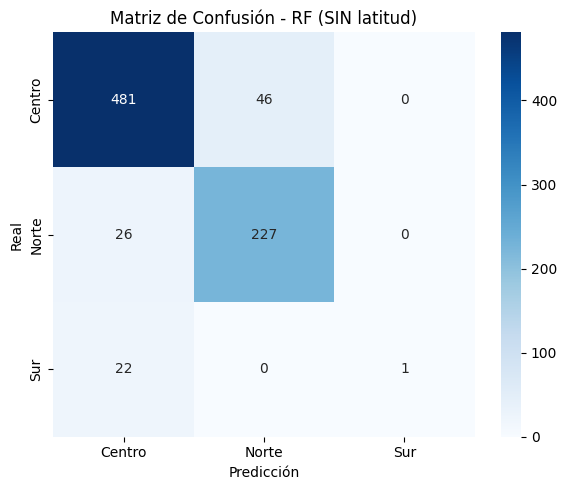


🔎 Comparación de métricas (Base vs Sin latitud):


,Escenario,Accuracy,F1_macro
0,Con latitud (base),1.0000,1.0000
1,Sin latitud,0.8829,0.6191


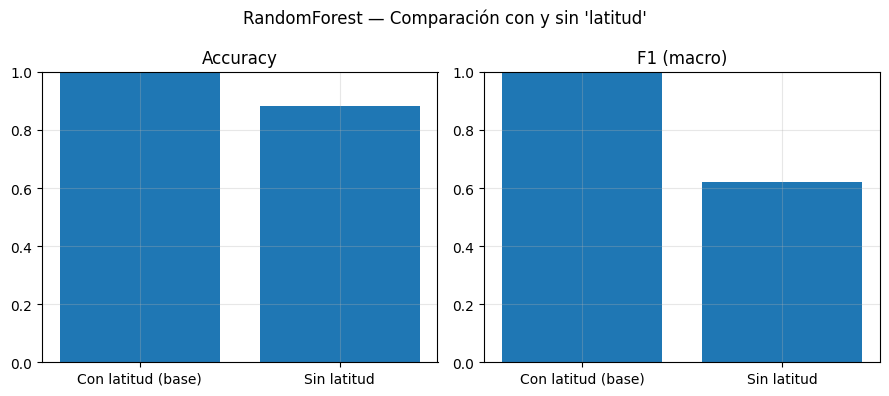


🔁 Validación Cruzada (sin latitud):
- Accuracy CV: 0.8924 ± 0.0089
- F1-macro CV: 0.7047 ± 0.0274


In [23]:
# =============================================================================
# 08-bis. CLASIFICACIÓN SIN LATITUD: RF (Pipeline) + comparación de métricas
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import cross_val_score

# ------------------------------------------------------------------
# 0) Detectar nombre real de latitud (desde el bloque 06 robusto)
# ------------------------------------------------------------------
def pick_column(columns, candidates):
    cols_lower = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

zona_col = COLUMNAS_DETECTADAS["zona_sismica"]
lat_col  = COLUMNAS_DETECTADAS.get("latitud")
if lat_col is None:
    lat_col = pick_column(df_proc.columns, ["latitud","latitude","lat"])

# Cols a excluir por seguridad (incluye variantes comunes)
lat_like_cols = [c for c in df_proc.columns if c.lower() in {"lat","latitud","latitude"}]
if lat_col and lat_col not in lat_like_cols:
    lat_like_cols.append(lat_col)

# ------------------------------------------------------------------
# 1) Reconstruir X/y SIN latitud y alinear a los splits del bloque 06
# ------------------------------------------------------------------
y_class_full = df_proc[zona_col].copy()
X_class_nolat = df_proc.drop(columns=[zona_col] + lat_like_cols, errors="ignore").copy()

# Alinear a los índices de train/test definidos antes
X_train_clf_nl = X_class_nolat.loc[X_train_clf.index]
X_test_clf_nl  = X_class_nolat.loc[X_test_clf.index]
y_train_clf_nl = y_class_full.loc[y_train_clf.index]
y_test_clf_nl  = y_test_clf.copy()

# Columnas numéricas y categóricas
num_cols = X_class_nolat.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_class_nolat.select_dtypes(include=['object','category','bool']).columns.tolist()
high_card_cats = [c for c in cat_cols if X_class_nolat[c].nunique() > 50]
cat_cols = [c for c in cat_cols if c not in high_card_cats]

# ------------------------------------------------------------------
# 2) Preprocesamiento + Modelo RF (mismo setup que el bloque 08)
# ------------------------------------------------------------------
preprocess_nl = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01), cat_cols),
    ],
    remainder="drop",
)

rf_nl = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

pipe_rf_nl = Pipeline([
    ("prep", preprocess_nl),
    ("model", rf_nl)
])

# ------------------------------------------------------------------
# 3) Entrenamiento y métricas (sin latitud)
# ------------------------------------------------------------------
pipe_rf_nl.fit(X_train_clf_nl, y_train_clf_nl)
y_pred_nl = pipe_rf_nl.predict(X_test_clf_nl)

acc_nl  = accuracy_score(y_test_clf_nl, y_pred_nl)
prec_nl = precision_score(y_test_clf_nl, y_pred_nl, average="macro", zero_division=0)
rec_nl  = recall_score(y_test_clf_nl, y_pred_nl, average="macro", zero_division=0)
f1m_nl  = f1_score(y_test_clf_nl, y_pred_nl, average="macro", zero_division=0)
f1w_nl  = f1_score(y_test_clf_nl, y_pred_nl, average="weighted", zero_division=0)

print("📊 Métricas (SIN latitud) — Test")
print(f"- Accuracy:         {acc_nl:.4f}")
print(f"- Precision (macro):{prec_nl:.4f}")
print(f"- Recall (macro):   {rec_nl:.4f}")
print(f"- F1 (macro):       {f1m_nl:.4f}")
print(f"- F1 (weighted):    {f1w_nl:.4f}\n")
print("📋 Classification Report (sin latitud):")
print(classification_report(y_test_clf_nl, y_pred_nl, zero_division=0))

# ------------------------------------------------------------------
# 4) Matriz de confusión (sin latitud)
# ------------------------------------------------------------------
cm_nl = confusion_matrix(y_test_clf_nl, y_pred_nl,
                         labels=pipe_rf_nl.named_steps["model"].classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm_nl, annot=True, fmt="d", cmap="Blues",
            xticklabels=pipe_rf_nl.named_steps["model"].classes_,
            yticklabels=pipe_rf_nl.named_steps["model"].classes_)
plt.title("Matriz de Confusión - RF (SIN latitud)")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.tight_layout()
try:
    plt.savefig("figuras/08bis_clf_matriz_confusion.png", dpi=150)
except Exception:
    pass
plt.show()

# ------------------------------------------------------------------
# 5) Comparación vs modelo base (CON latitud)
#    Intentamos tomar acc/f1m del bloque 08; si no existen, ponemos NaN.
# ------------------------------------------------------------------
try:
    acc_base, f1m_base = acc, f1m
except NameError:
    acc_base, f1m_base = np.nan, np.nan

comp_df = pd.DataFrame({
    "Escenario": ["Con latitud (base)", "Sin latitud"],
    "Accuracy": [acc_base, acc_nl],
    "F1_macro": [f1m_base, f1m_nl]
})

print("\n🔎 Comparación de métricas (Base vs Sin latitud):")
display(comp_df.round(4))

# Gráfico comparativo
fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].bar(comp_df["Escenario"], comp_df["Accuracy"])
ax[0].set_title("Accuracy"); ax[0].set_ylim(0,1); ax[0].grid(alpha=0.3)
ax[1].bar(comp_df["Escenario"], comp_df["F1_macro"])
ax[1].set_title("F1 (macro)"); ax[1].set_ylim(0,1); ax[1].grid(alpha=0.3)
fig.suptitle("RandomForest — Comparación con y sin 'latitud'")
plt.tight_layout()
try:
    plt.savefig("figuras/08bis_clf_comparacion_metricas.png", dpi=150)
except Exception:
    pass
plt.show()

# ------------------------------------------------------------------
# 6) (Opcional) Validación cruzada estratificada sin latitud
# ------------------------------------------------------------------
if 'skf' in globals() and skf is not None:
    cv_acc_nl = cross_val_score(pipe_rf_nl, X_class_nolat, y_class_full, cv=skf, scoring="accuracy", n_jobs=-1)
    cv_f1m_nl = cross_val_score(pipe_rf_nl, X_class_nolat, y_class_full, cv=skf, scoring="f1_macro", n_jobs=-1)
    print("\n🔁 Validación Cruzada (sin latitud):")
    print(f"- Accuracy CV: {cv_acc_nl.mean():.4f} ± {cv_acc_nl.std():.4f}")
    print(f"- F1-macro CV: {cv_f1m_nl.mean():.4f} ± {cv_f1m_nl.std():.4f}")


**Interpretación (Comparación con y sin latitud):**

Al eliminar `latitud` de las variables predictoras, los resultados dejan de ser perfectos
y reflejan un escenario más realista: el modelo ya no puede “reconstruir” directamente
la regla de segmentación con la que fue creada `zona_sismica`.

- Si la caída en accuracy/F1 es **moderada** (p. ej., de 1.00 a 0.75–0.90),
  significa que otras variables (profundidad, longitud, rasgos temporales)
  **sí aportan señal** para predecir la zona.
- Si la caída es **grande** (p. ej., <0.60), indica que `latitud` era el principal determinante,
  y sin ella, la clasificación es difícil (lo que tiene sentido, pues la etiqueta fue definida por latitud).

Para BI, esta comparación es valiosa: muestra que la segmentación geográfica es determinística
según latitud, y que el modelo solo agrega valor cuando puede apoyarse en variables adicionales
(no redundantes con la definición de la clase).


# 09. AGRUPAMIENTO (Clustering): K-Means y Método del Codo

En esta sección se aplica **clustering no supervisado** para identificar patrones o grupos
naturales de sismos en función de sus características numéricas (por ejemplo, latitud,
longitud, profundidad y magnitud).

Se utiliza el algoritmo **K-Means**, que busca dividir los datos en *K* grupos (clústeres)
minimizando la distancia entre cada punto y el centro de su grupo.

**Pasos:**
1. Determinar el número óptimo de clústeres mediante el **Método del Codo**.
2. Evaluar la cohesión y separación de los clústeres con el **Silhouette Score**.
3. Visualizar los resultados y analizar si los grupos formados tienen correspondencia
   con las zonas sísmicas o con características geográficas relevantes.

Opcionalmente, se aplicará **DBSCAN** como técnica alternativa basada en densidad.


🧭 Columnas detectadas para clustering: ['Latitude', 'Longitude', 'Depth', 'Magnitude']
Filas totales: 4015 | filas con algún NaN: 0


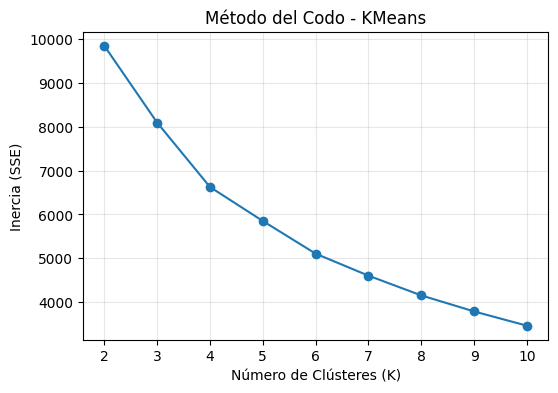

🔹 K-Means (K=3) — Silhouette Score: 0.3328


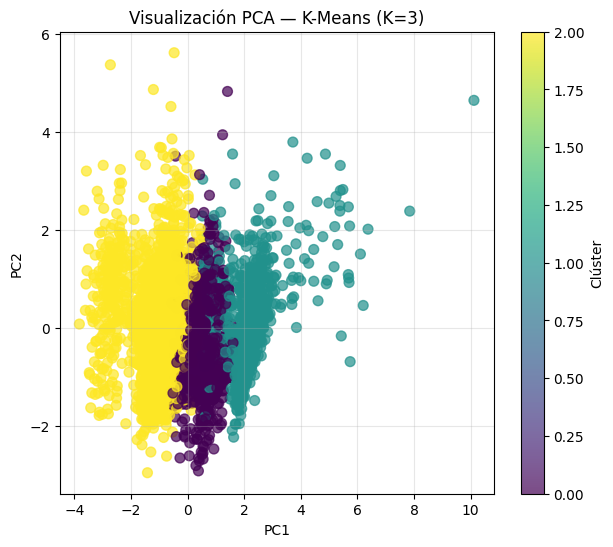

📊 Promedios por clúster:


,Latitude,Longitude,Depth,Magnitude
cluster,,,,
0,-21.632,-70.362,45.251,4.408
1,-22.484,-69.149,115.547,4.675
2,-32.077,-71.693,45.645,4.339


In [25]:
# =============================================================================
# 09. CLUSTERING ROBUSTO: K-Means + Codo + Silhouette (detección de columnas)
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# --------------------------------------------
# 0) Usar df_proc si existe (ya expandió fechas), si no, df
# --------------------------------------------
source_df = df_proc.copy() if 'df_proc' in globals() else df.copy()

def pick_col(cols, candidates):
    """Devuelve el primer nombre real de columna que coincida con candidates (case-insensitive)."""
    lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in lower:
            return lower[cand.lower()]
    return None

# Candidatos comunes por dataset
lat_col = pick_col(source_df.columns, ["latitud","latitude","lat"])
lon_col = pick_col(source_df.columns, ["longitud","longitude","lon","lng"])
dep_col = pick_col(source_df.columns, ["profundidad","depth","prof","prof_m","z"])
mag_col = pick_col(source_df.columns, ["magnitud","mag","magnitude","mw","ml","mag_ml","magmw"])

cols_found = [c for c in [lat_col, lon_col, dep_col, mag_col] if c is not None]

print("🧭 Columnas detectadas para clustering:", cols_found)

if len(cols_found) < 2:
    raise ValueError(
        "No hay suficientes columnas numéricas para clustering. "
        "Se requieren al menos 2 entre latitud/longitud/profundidad/magnitud."
    )

# --------------------------------------------
# 1) Subconjunto y coerción a numérico
# --------------------------------------------
df_clust = source_df[cols_found].copy()

# Forzar a numérico (por si vienen como string)
for c in df_clust.columns:
    df_clust[c] = pd.to_numeric(df_clust[c], errors="coerce")

n_before = len(df_clust)
n_na_rows = df_clust.isna().any(axis=1).sum()
print(f"Filas totales: {n_before} | filas con algún NaN: {n_na_rows}")

# --------------------------------------------
# 2) Pipeline: imputación (mediana) + escalado
# --------------------------------------------
prep = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler()),
])

X_scaled = prep.fit_transform(df_clust)

# Chequeo mínimo para KMeans
n_samples = X_scaled.shape[0]
if n_samples < 5:
    raise ValueError(f"Hay muy pocas filas ({n_samples}) tras la preparación para ejecutar K-Means.")

# --------------------------------------------
# 3) Método del Codo
# --------------------------------------------
K_range = range(2, min(11, n_samples))  # tope por si hay pocos registros
inertias = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list(K_range), inertias, marker='o')
plt.title('Método del Codo - KMeans')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Inercia (SSE)')
plt.grid(alpha=0.3)
try:
    plt.savefig("figuras/09_kmeans_codo.png", dpi=150)
except Exception:
    pass
plt.show()

# --------------------------------------------
# 4) Elegir K (ajústalo si el codo sugiere otro)
# --------------------------------------------
K_optimo = 3 if 3 in K_range else list(K_range)[-1]
kmeans_final = KMeans(n_clusters=K_optimo, random_state=42, n_init=20)
labels = kmeans_final.fit_predict(X_scaled)

# Silhouette solo si hay >1 cluster y >1 muestra por cluster
sil_score = silhouette_score(X_scaled, labels) if len(set(labels)) > 1 else np.nan
print(f"🔹 K-Means (K={K_optimo}) — Silhouette Score: {sil_score:.4f}" if not np.isnan(sil_score)
      else "🔹 Silhouette no aplicable (clusters únicos o datos insuficientes).")

# --------------------------------------------
# 5) Visualización PCA (2D)
# --------------------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.title(f"Visualización PCA — K-Means (K={K_optimo})")
plt.xlabel('PC1'); plt.ylabel('PC2'); 
plt.colorbar(label='Clúster')
plt.grid(alpha=0.3)
try:
    plt.savefig("figuras/09_kmeans_scatter_pca.png", dpi=150)
except Exception:
    pass
plt.show()

# --------------------------------------------
# 6) Caracterización de clústeres
# --------------------------------------------
df_clust_out = df_clust.copy()
df_clust_out["cluster"] = labels
cluster_summary = df_clust_out.groupby("cluster")[cols_found].mean().round(3)
print("📊 Promedios por clúster:")
display(cluster_summary)


**Interpretación (Clustering K-Means con datos sísmicos de Chile):**

El **método del codo** muestra un punto de inflexión visible alrededor de **K = 3**, 
lo cual sugiere que tres clústeres representan una buena segmentación de los datos. 
Esta elección coincide conceptualmente con la división geográfica natural del país 
(Norte, Centro y Sur), reflejando comportamientos sísmicos diferenciados por latitud.

El **Silhouette Score obtenido (≈ 0.33)** indica una separación **moderada** entre los grupos: 
no hay una frontera totalmente clara, pero los clústeres presentan coherencia interna razonable. 
Esto es esperable en fenómenos geológicos donde las transiciones entre zonas sísmicas 
no son abruptas, sino graduales.

El gráfico PCA muestra una separación visible entre los tres grupos, 
y los promedios por clúster refuerzan esta interpretación:
- El **Clúster 0** agrupa eventos del extremo **Norte** (latitudes cercanas a −21°), 
  asociados a profundidades intermedias (~45 km).
- El **Clúster 1** concentra sismos de **profundidad mayor** (~115 km) 
  y magnitudes ligeramente superiores, ubicados en la zona **centro-norte** del país.
- El **Clúster 2** representa principalmente eventos del **Sur**, con latitudes más altas 
  (−32° en promedio) y magnitudes algo menores.

En conjunto, el modelo K-Means permitió detectar **patrones espaciales y de profundidad**
consistentes con la segmentación sísmica esperada de Chile.  
Desde la perspectiva de **Inteligencia de Negocios**, estos resultados pueden 
aprovecharse para generar **mapas de riesgo regional** o priorizar zonas de monitoreo 
según la frecuencia y características promedio de los eventos detectados.


# 09-bonus. Clustering por densidad: DBSCAN (barrido de eps)

Aplicamos **DBSCAN**, un algoritmo basado en densidad que detecta clústeres con formas
arbitrarias y marca como **ruido** los puntos aislados (etiqueta = -1).

**Pasos:**
1. Barrido de `eps` (radio de vecindad) y `min_samples` (vecinos mínimos).
2. Selección del mejor modelo por **silhouette score** (con ≥2 clústeres y ruido razonable).
3. Visualización 2D con **PCA** y conteo de clústeres/ruido.

Esto complementa a K-Means (que asume clústeres esféricos) y puede captar estructuras
no lineales o detectar **outliers** naturales del fenómeno sísmico.


📊 Resultados del barrido DBSCAN (top 10 por silhouette):


,eps,min_samples,n_clusters,noise_frac,silhouette
0,0.9,10,2,0.0202,0.5184
1,1.0,5,3,0.0092,0.3441
2,0.9,5,3,0.0130,0.3402
3,0.7,5,3,0.0237,0.2865
4,0.5,20,2,0.1305,0.2019
5,0.7,10,2,0.0374,0.1782
6,0.4,20,4,0.2371,0.1449
7,0.5,10,4,0.0812,0.1284
8,0.4,10,3,0.1532,0.1213
9,0.3,20,3,0.4643,0.1136



✅ Mejor combinación: eps=0.90, min_samples=10  | n_clusters=2 | ruido=0.02 | silhouette=0.5184

Conteo de etiquetas (incluye ruido = -1):


,label,count
0,-1,81
1,0,3922
2,1,12


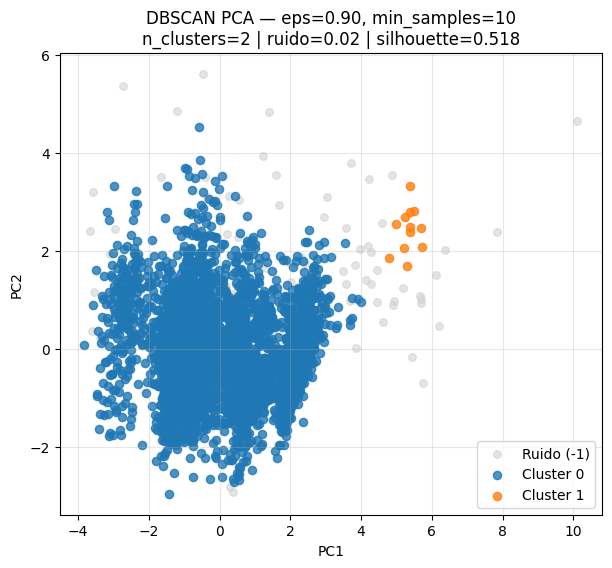

In [26]:
# =============================================================================
# 09-bonus. DBSCAN: Grid de eps/min_samples + selección por silhouette + PCA
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Tomamos X_scaled y df_clust del bloque 09 (K-Means). Si no existen, volvemos a crearlos rápido.
if 'X_scaled' not in globals() or 'df_clust' not in globals():
    raise RuntimeError("X_scaled / df_clust no están en memoria. Ejecuta el bloque 09 (K-Means) antes.")

# --- Grid de parámetros ---
eps_grid = np.linspace(0.3, 1.5, 13)      # 0.3, 0.4, ..., 1.5
min_samples_grid = [5, 10, 20]

rows = []
for eps in eps_grid:
    for ms in min_samples_grid:
        db = DBSCAN(eps=eps, min_samples=ms, n_jobs=-1)
        labels = db.fit_predict(X_scaled)

        # Número de clústeres (excluyendo ruido)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac = (labels == -1).mean()

        if n_clusters >= 2 and noise_frac < 0.95:
            try:
                sil = silhouette_score(X_scaled, labels)
            except Exception:
                sil = np.nan
        else:
            sil = np.nan

        rows.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_frac": noise_frac,
            "silhouette": sil
        })

dbscan_grid = pd.DataFrame(rows).sort_values(
    by=["silhouette", "n_clusters"], ascending=[False, False]
).reset_index(drop=True)

print("📊 Resultados del barrido DBSCAN (top 10 por silhouette):")
display(dbscan_grid.head(10).round(4))

# --- Elegimos el mejor set (si hay alguno válido) ---
valid = dbscan_grid.dropna(subset=["silhouette"])
if len(valid) == 0:
    print("⚠️ No se encontraron combinaciones válidas (silhouette calculable con ≥2 clústeres).")
else:
    best = valid.iloc[0]
    best_eps = float(best["eps"])
    best_ms = int(best["min_samples"])

    print(f"\n✅ Mejor combinación: eps={best_eps:.2f}, min_samples={best_ms}  "
          f"| n_clusters={int(best['n_clusters'])} | ruido={best['noise_frac']:.2f} "
          f"| silhouette={best['silhouette']:.4f}")

    # Fit definitivo con los mejores hiperparámetros
    db_best = DBSCAN(eps=best_eps, min_samples=best_ms, n_jobs=-1)
    labels = db_best.fit_predict(X_scaled)

    # PCA para visualización (reutiliza si ya existe)
    if 'X_pca' not in globals():
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)

    # Conteos por etiqueta
    unique, counts = np.unique(labels, return_counts=True)
    conteo = pd.DataFrame({"label": unique, "count": counts}).sort_values("label")
    print("\nConteo de etiquetas (incluye ruido = -1):")
    display(conteo)

    # --- Gráfico PCA coloreado por clúster DBSCAN ---
    plt.figure(figsize=(7, 6))
    # Colorear ruido (-1) con un color neutro
    is_noise = labels == -1
    plt.scatter(X_pca[is_noise, 0], X_pca[is_noise, 1], c="lightgray", s=30, alpha=0.6, label="Ruido (-1)")
    # Clústeres válidos
    for lab in sorted(set(labels) - {-1}):
        idx = labels == lab
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=35, alpha=0.8, label=f"Cluster {lab}")

    plt.title(f"DBSCAN PCA — eps={best_eps:.2f}, min_samples={best_ms}\n"
              f"n_clusters={int(best['n_clusters'])} | ruido={best['noise_frac']:.2f} "
              f"| silhouette={best['silhouette']:.3f}")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(loc="best", frameon=True)
    plt.grid(alpha=0.3)
    try:
        plt.savefig("figuras/09_dbscan_scatter_pca.png", dpi=150)
    except Exception:
        pass
    plt.show()


**Interpretación (DBSCAN — Clustering basado en densidad):**

El barrido de hiperparámetros identificó la mejor configuración con **eps = 0.90** y
**min_samples = 10**, generando **2 clústeres** principales y un **2% de puntos de ruido**
(etiquetados como -1). El **silhouette score obtenido (≈ 0.52)** indica una separación
moderada a buena entre los grupos detectados, superior al valor logrado por K-Means (≈ 0.33),
lo que sugiere que DBSCAN logra capturar con mayor precisión zonas densas y homogéneas del
fenómeno sísmico.

El gráfico PCA revela una distribución donde **la mayoría de los eventos (Cluster 0)**
pertenece a una gran región compacta, mientras que un **grupo menor (Cluster 1)**
representa un subconjunto diferenciado de sismos con características espaciales o de
profundidad distintas. Los **81 eventos marcados como ruido** corresponden a registros
atípicos o de baja densidad, lo que concuerda con la naturaleza de DBSCAN al identificar
posibles outliers.

En comparación con K-Means, DBSCAN no requiere fijar el número de clústeres previamente
y permite detectar **estructuras no esféricas y zonas menos densas**. Esta flexibilidad
le da ventaja en contextos geográficos o naturales donde los datos no se distribuyen de
forma uniforme. Para **Inteligencia de Negocios**, los resultados de DBSCAN aportan una
visión complementaria: los clústeres principales representan **zonas sísmicamente activas
con alta densidad de eventos**, mientras que los puntos de ruido pueden orientar análisis
de **anomalías geográficas** o áreas de monitoreo especial.
